In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
     

In [2]:
!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

 77% 65.0M/84.3M [00:00<00:00, 138MB/s]
100% 84.3M/84.3M [00:00<00:00, 148MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/covid19-xray-dataset-train-test-sets.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
     

In [5]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/xray_dataset_covid19/train',
    labels='inferred',
    label_mode = 'int',
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/xray_dataset_covid19/test',
    labels='inferred',
    label_mode = 'int',
    image_size=(256,256)
)
     

Found 148 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


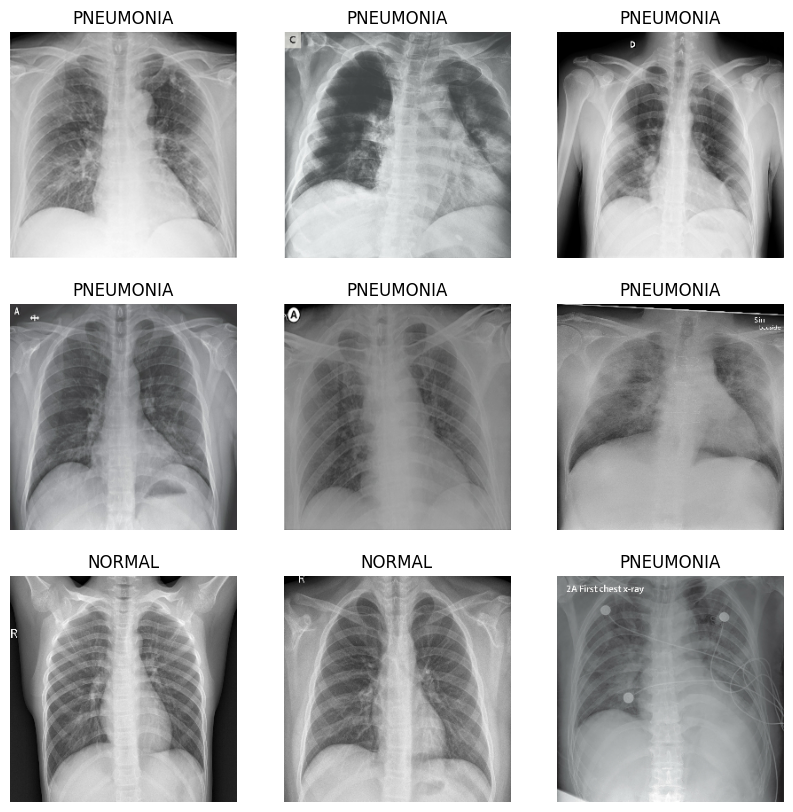

In [6]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")



In [7]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
test_datagen=ImageDataGenerator(rescale=1./255)

In [8]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding="valid",activation="relu",input_shape=(256,256,3)))
model.add(Conv2D(64,kernel_size=(3,3),padding="valid",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.3))
model.add(Conv2D(64,kernel_size=(3,3),padding="valid",activation="relu"))
model.add(Conv2D(64,kernel_size=(3,3),padding="valid",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.3))
model.add(Conv2D(128,kernel_size=(3,3),padding="valid",activation="relu"))
model.add(Conv2D(128,kernel_size=(3,3),padding="valid",activation="relu"))
model.add(Conv2D(128,kernel_size=(3,3),padding="valid",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.3))
model.add(Conv2D(128,kernel_size=(3,3),padding="valid",activation="relu"))
model.add(Conv2D(256,kernel_size=(3,3),padding="valid",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2,activation="softmax"))


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 64)      36928     
                                                        

In [10]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="Adam",metrics=['accuracy'])

In [12]:
history=model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
5/5 [==============================] - 4s 375ms/step - loss: 0.3258 - accuracy: 0.8649 - val_loss: 0.3082 - val_accuracy: 0.9000
Epoch 2/10
5/5 [==============================] - 4s 448ms/step - loss: 0.3259 - accuracy: 0.8919 - val_loss: 0.4143 - val_accuracy: 0.9250
Epoch 3/10
5/5 [==============================] - 4s 378ms/step - loss: 0.3514 - accuracy: 0.8243 - val_loss: 0.4723 - val_accuracy: 0.9500
Epoch 4/10
5/5 [==============================] - 4s 382ms/step - loss: 0.2854 - accuracy: 0.8986 - val_loss: 0.3375 - val_accuracy: 0.9000
Epoch 5/10
5/5 [==============================] - 4s 455ms/step - loss: 0.2832 - accuracy: 0.8986 - val_loss: 0.3894 - val_accuracy: 0.9750
Epoch 6/10
5/5 [==============================] - 4s 379ms/step - loss: 0.3321 - accuracy: 0.8446 - val_loss: 0.4476 - val_accuracy: 0.9500
Epoch 7/10
5/5 [==============================] - 4s 380ms/step - loss: 0.2459 - accuracy: 0.9054 - val_loss: 0.2812 - val_accuracy: 0.9500
Epoch 8/10
5/5 [====

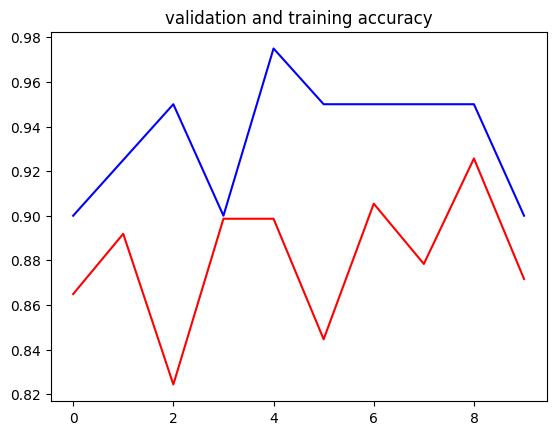

In [13]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label="validation")
plt.title("validation and training accuracy")
plt.show()


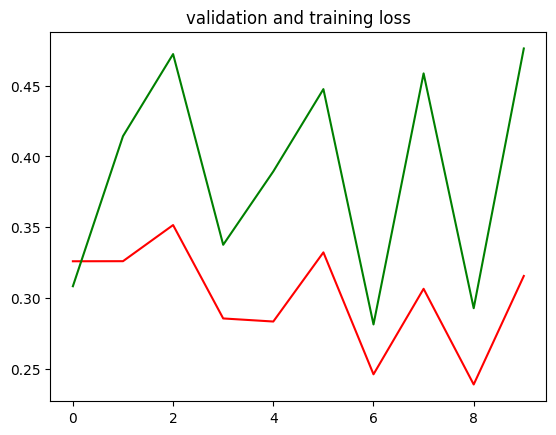

In [14]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='green',label='validation')
plt.title("validation and training loss")
plt.show()

In [15]:
import numpy as np
results=model.evaluate(train_ds,verbose=0)
print("test loss:{:.5f}".format(results[0]))
print("Accuracy on the training set: {:.02f}".format(results[1]*100))


test loss:0.46883
Accuracy on the training set: 89.86


In [16]:
Class=[]
for file in os.listdir("/content/xray_dataset_covid19/train"):
 Class+=[file]
print(Class)
print(len(Class))

['PNEUMONIA', 'NORMAL']
2


In [17]:
Class=[]
for file in os.listdir('/content/xray_dataset_covid19/test'):
 Class+=[file]
print(Class)
print(len(Class))

['PNEUMONIA', 'NORMAL']
2


1/1 [==============================] - 0s 32ms/step


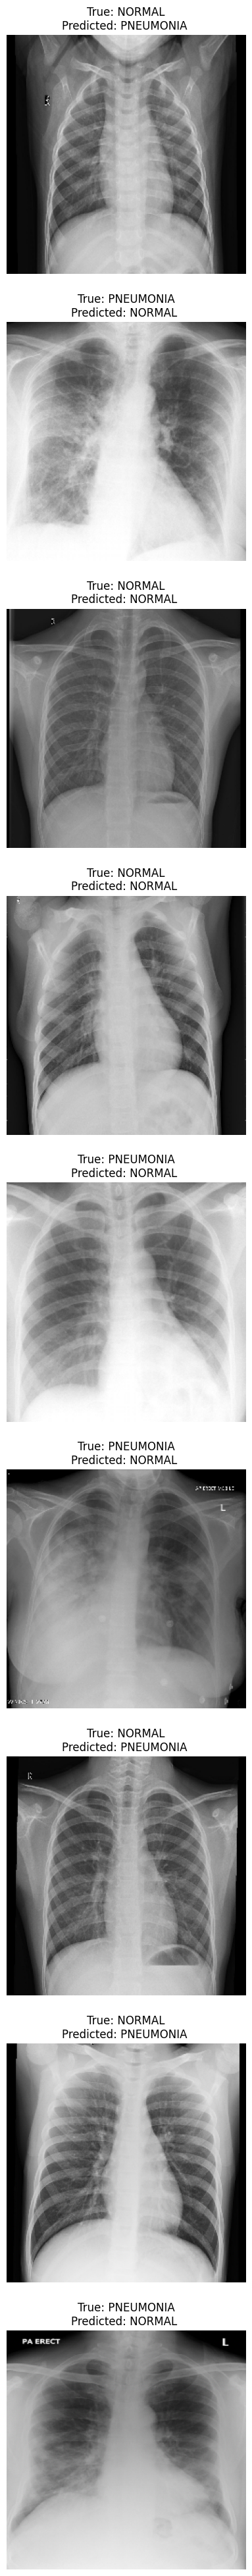

In [20]:
plt.figure(figsize=(10,50))
for images,labels in validation_ds.take(1):
  prediction=model.predict(images,batch_size=32)
  for i in range(9):
    ax=plt.subplot(9,1,i+1)
    pred=np.argmax(prediction[i])
    plt.imshow(images[i].numpy().astype("uint8"))
    true=validation_ds.class_names[labels[i]]
    plt.title(f"True: {true}\nPredicted: { Class[pred] } ")
    plt.axis('off')